## Анализ поведения пользователей в обновлённом приложении Quiz Freez

ЗАДАЧИ

- Определить, насколько обучение сокращает время прохождения этапов игры.
- Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
- Определить, насколько прозрачен процесс взаимодействия с игрой.

Выполнять анализ необходимо на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно):

In [1]:
import pandas as pd

# чтение данныx
events_data = pd.read_csv('Events.csv', sep=',')
purchases_data = pd.read_csv('purchase.csv', sep=',')

events_df = events_data.copy()
purchase_df = purchases_data.copy()

# Оставляем в таблицах только те данные пользователей, которые были зарегистрированы в 2018 году:

mask_date = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type'] == 'registration')
ids = events_df[mask_date]['user_id']

mask_user_event = events_df['user_id'].isin(ids)
events_df = events_df[mask_user_event]
events_df.start_time = pd.to_datetime(events_df.start_time, format='%Y-%m-%dT%H:%M:%S')

mask_user_purchase = purchase_df['user_id'].isin(ids)
purchase_df = purchase_df[mask_user_purchase]
purchase_df['event_datetime']=pd.to_datetime(purchase_df['event_datetime'])

Для анализа всех этапов игры, объединим таблицы Event и Purchase в DF total_events_df:

In [2]:
# Добавим в датафрейм purchase_df столбец event_type, который будет содержать одно значение purchase. 
# Это нужно, чтобы в объединённом датафрейме однозначно выделить события оплаты.
purchase_df['event_type'] = 'purchase'

# Также у нас есть одинаковые столбцы id в двух датафреймах, но смысл их несколько отличается, 
# так как столбец id в events_df указывает на идентификатор события, 
# а столбец id в purchase_df указывает на идентификатор оплаты. 
# Поэтому применим функцию rename(), чтобы переименовать столбцы в датафреймах.
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id"})

# объединим датафреймы events_df и purchase_df с помощью функции pd.concat() и запишем объединённый датафрейм в total_events_df.
total_events_df = pd.concat([events_df,purchase_df],sort=False)

# Теперь сбросим индексы объединённого датафрейма (так как после объединения они дублировались и несут мало смысла) 
# с помощью метода reset_index() и отсортируем все события по возрастанию времени с помощью sort_values().
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

Создадим новый столбец tutorial_user_YN (yes/no), который разделяет пользователей на группы:
- Пользователи, не начинавшие обучение (значение False)
- Пользователи, которые завершили обучение (значение True)
- Пользователи, которые начинали обучение, но не завершили его (значение None). Таких пользователей мы не будем включать в анализ.

In [3]:
# Новый столбец. По умолчанию зададим False
total_events_df['tutorial_user_YN'] = 'False'
# Пользователи, которые завершили обучение
tutorial_users_finish = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].to_list()
# Пользователи, которые начинали обучение
tutorial_users_start = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].to_list()

# Цикл по строкам в таблице. Для всех пользователей, которые завершили обучение, присваиваем значение нового столба True.
for index, row in total_events_df.iterrows(): 
    if row['user_id'] in tutorial_users_finish:
        total_events_df.loc[index, 'tutorial_user_YN'] = 'True'

# Цикл по строкам в таблице. Для всех пользователей, которые начинали обучение, 
# но не завершили его, присваиваем значение нового столба None.
for index, row in total_events_df.iterrows():
    if (row['user_id'] in tutorial_users_start) & (row['user_id'] not in tutorial_users_finish):
        total_events_df.loc[index, 'tutorial_user_YN'] = 'None'

# Самопроверка:
print("Количество всех уникальных пользователей: {}".format(
    total_events_df["user_id"].nunique()))
print("Количество пользователей, завершивших обучение: {}".format(
    total_events_df[total_events_df['tutorial_user_YN'] == 'True']["user_id"].nunique()))
print("Количество пользователей, не начинавших обучение: {}".format(
    total_events_df[total_events_df['tutorial_user_YN'] == 'False']["user_id"].nunique()))
print("Количество пользователей, начинавших обучение, но не завершивших его: {}".format(
    total_events_df[total_events_df['tutorial_user_YN'] == 'None']["user_id"].nunique()))

Количество всех уникальных пользователей: 19926
Количество пользователей, завершивших обучение: 10250
Количество пользователей, не начинавших обучение: 8068
Количество пользователей, начинавших обучение, но не завершивших его: 1608


1. Определяем, насколько обучение сокращает время прохождения этапов игры. Для этого:
 - сравним время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. 
 - если показатель отличается, выясним, насколько.

In [4]:
# разница (timedelta_level_pack) между level_choice (выбор уровня сложности) и pack_choice (выбор пакета вопросов)

level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice']
level_choice_df = level_choice_df[["user_id", "start_time", "tutorial_user_YN"]].rename(columns={"start_time": "level_choice_time"})

pack_choice_df = total_events_df[total_events_df['event_type'] == 'pack_choice']
pack_choice_df = pack_choice_df[["user_id", "start_time", "tutorial_user_YN"]].rename(columns={"start_time": "pack_choice_time"})

merged_level_pack = level_choice_df.merge(pack_choice_df, on=["user_id", "tutorial_user_YN"], how="inner")
merged_level_pack["timedelta_level_pack"] = (merged_level_pack["pack_choice_time"] - merged_level_pack["level_choice_time"])

# разница (timedelta_pack_purchase) между pack_choice (выбор пакета вопросов) и purchase (оплата)

purchase_df = total_events_df[total_events_df["event_type"] == "purchase"]
purchase_df = purchase_df[["user_id", "event_datetime", "tutorial_user_YN"]].rename(columns={"event_datetime": "purchase_time"})

merged_level_pack_purchase = merged_level_pack.merge(purchase_df, on=["user_id", "tutorial_user_YN"], how="inner")
merged_level_pack_purchase['timedelta_pack_purchase'] = (
    merged_level_pack_purchase["purchase_time"] - merged_level_pack_purchase["pack_choice_time"])

# разница между registration и purchase (оплата) - весь путь

registration_df = total_events_df[total_events_df['event_type'] == 'registration']
registration_df = registration_df[["user_id", "start_time", "tutorial_user_YN"]].rename(columns={"start_time": "registration_time"})

merged_level_pack_purchase_reg = merged_level_pack_purchase.merge(registration_df, on=["user_id", "tutorial_user_YN"], how="inner")
merged_level_pack_purchase_reg['timedelta_reg_purchase'] = (
    merged_level_pack_purchase_reg["purchase_time"] - merged_level_pack_purchase_reg["registration_time"])


#print('\nСрез таблицы:')
#merged_level_pack_purchase_reg.head()

print(' *** Анализ для пользователей, которые завершили обучение ***')
mask_tutorial = merged_level_pack_purchase_reg['tutorial_user_YN'] == 'True'

print('\nСреднее время между выбором уровня сложности и выбором пакета вопросов:', 
      merged_level_pack_purchase_reg[mask_tutorial]["timedelta_level_pack"].mean())
print('Среднее время между выбором пакета вопросов и оплатой:                 ', 
      merged_level_pack_purchase_reg[mask_tutorial]['timedelta_pack_purchase'].mean())
print('Среднее время между регистрацией и оплатой (весь путь):                ', 
      merged_level_pack_purchase_reg[mask_tutorial]['timedelta_reg_purchase'].mean())

print('\n *** Анализ для пользователей, не начинавших обучение ***')
mask_not_tutorial = merged_level_pack_purchase_reg['tutorial_user_YN'] == 'False'

print('\nСреднее время между выбором уровня сложности и выбором пакета вопросов:', 
      merged_level_pack_purchase_reg[mask_not_tutorial]["timedelta_level_pack"].mean())
print('Среднее время между выбором пакета вопросов и оплатой:                 ', 
      merged_level_pack_purchase_reg[mask_not_tutorial]['timedelta_pack_purchase'].mean())
print('Среднее время между регистрацией и оплатой (весь путь):                ', 
      merged_level_pack_purchase_reg[mask_not_tutorial]['timedelta_reg_purchase'].mean())

 *** Анализ для пользователей, которые завершили обучение ***

Среднее время между выбором уровня сложности и выбором пакета вопросов: 0 days 00:05:25.313061506
Среднее время между выбором пакета вопросов и оплатой:                  3 days 17:17:59.641326883
Среднее время между регистрацией и оплатой (весь путь):                 4 days 00:30:03.247408431

 *** Анализ для пользователей, не начинавших обучение ***

Среднее время между выбором уровня сложности и выбором пакета вопросов: 0 days 00:05:22.681818181
Среднее время между выбором пакета вопросов и оплатой:                  4 days 04:49:33.590909090
Среднее время между регистрацией и оплатой (весь путь):                 4 days 09:06:01.909090909


В рамках первой гипотезы построим столбчатую диаграмму, отражающую время прохождения различных этапов для пользователей, которые прошли обучение, и для пользователей, не начинавших обучение.

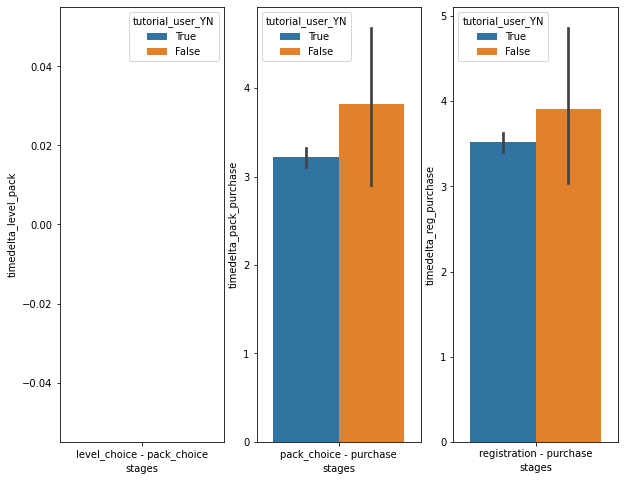

In [5]:
# Для построения визуализаций используем библиотеки Matplotlib или Seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.mode.chained_assignment = None  
# уберем пользователей, которые начинали обучение, но не завершили его
merged_level_pack_purchase_reg = merged_level_pack_purchase_reg[merged_level_pack_purchase_reg['tutorial_user_YN'] != 'None']

# создадим 3 таблицы с интересующими нас этапами
# разницу во времени переведём в дни
table_level_pack = merged_level_pack_purchase_reg[['tutorial_user_YN', 'timedelta_level_pack']]
table_level_pack.insert(2, "stages", "level_choice - pack_choice", True)
table_level_pack['timedelta_level_pack'] = table_level_pack['timedelta_level_pack'].dt.days

table_pack_purchase = merged_level_pack_purchase_reg[['tutorial_user_YN', 'timedelta_pack_purchase']]
table_pack_purchase.insert(2, "stages", "pack_choice - purchase", True)
table_pack_purchase['timedelta_pack_purchase'] = table_pack_purchase['timedelta_pack_purchase'].dt.days

table_reg_purchase = merged_level_pack_purchase_reg[['tutorial_user_YN', 'timedelta_reg_purchase']]
table_reg_purchase.insert(2, "stages", "registration - purchase", True)
table_reg_purchase['timedelta_reg_purchase'] = table_reg_purchase['timedelta_reg_purchase'].dt.days

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

axes[0].barplot = sns.barplot(
    data=table_level_pack,
    x='stages',
    y='timedelta_level_pack',
    hue='tutorial_user_YN',
    ax=axes[0]
)

axes[1].barplot = sns.barplot(
    data=table_pack_purchase,
    x='stages',
    y='timedelta_pack_purchase',
    hue='tutorial_user_YN',
    ax=axes[1]
)

axes[2].barplot = sns.barplot(
    data=table_reg_purchase,
    x='stages',
    y='timedelta_reg_purchase',
    hue='tutorial_user_YN',
    ax=axes[2]
)


ВЫВОД:
среднее время между выбором уровня сложности и выбором пакета вопросов пракически не отличается для пользователей, которые прошли обучение и для тех, кто его не начинал.
Но среднее время между выбором пакета вопросов и оплатой больше у пользователей, не начинавших обучение в среднем на 12 часов.
Кроме того, проанализировав время всего пути, можно сказать, что обучение сокращает время прохождения этапов игры в среднем на 9 часов.
Это значит, обучение влияет на момент покупки (приближает к ней).

2. Докажем, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
Для этого проверим, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

Создадим таблицу с пользователи, которые прошли обучение и которые купили вопросы:

In [6]:
mask_all_tutorial = total_events_df['tutorial_user_YN'] == 'True'
mask_tutorial_start = total_events_df['event_type'] == 'tutorial_start'
mask_purchase = total_events_df['event_type'] == 'purchase'
# таблицы, с пользователи, которые прошли обучение и которые купили вопросы
df_tutorial_start = total_events_df[mask_all_tutorial & mask_tutorial_start]
df_purchase = total_events_df[mask_all_tutorial & mask_purchase]

merged_tutorial_purchase = df_tutorial_start.merge(df_purchase, on=["user_id"], how="outer")

merged_tutorial_purchase.drop(
    labels=['event_id_x', 'selected_level_x', 'tutorial_id_x', 'purchase_id_x', 'event_datetime_x', 'amount_x', 'tutorial_user_YN_x',
            'event_id_y', 'selected_level_y', 'tutorial_id_y', 'purchase_id_y', 'event_datetime_y', 'amount_y', 'tutorial_user_YN_y'], 
    axis=1, inplace = True)
# срез объединённой таблицы
merged_tutorial_purchase.head()

,event_type_x,start_time_x,user_id,event_type_y,start_time_y
0,tutorial_start,2018-01-01 14:54:40,27836,NaN,NaT
1,tutorial_start,2018-01-01 15:40:43,27836,NaN,NaT
2,tutorial_start,2018-01-01 15:00:51,27835,NaN,NaT
3,tutorial_start,2018-01-01 17:47:40,27833,NaN,NaT
4,tutorial_start,2018-01-01 19:11:36,27839,NaN,NaT


Создадим новый столбец count_tutorial, которые показывает число обучений пользователя.

In [7]:
merged_tutorial_purchase['count_tutorial'] = 0

# Цикл по строкам в таблице. Для всех пользователей, которые завершили обучение, присваиваем значение нового столба - 
# количество прохождений обучения.
for index, row in merged_tutorial_purchase.iterrows(): 
    count = merged_tutorial_purchase[merged_tutorial_purchase['user_id'] == row['user_id']].start_time_x.count()
    merged_tutorial_purchase.loc[index, 'count_tutorial'] = count

merged_tutorial_purchase.head(10)

,event_type_x,start_time_x,user_id,event_type_y,start_time_y,count_tutorial
0,tutorial_start,2018-01-01 14:54:40,27836,NaN,NaT,2
1,tutorial_start,2018-01-01 15:40:43,27836,NaN,NaT,2
2,tutorial_start,2018-01-01 15:00:51,27835,NaN,NaT,1
3,tutorial_start,2018-01-01 17:47:40,27833,NaN,NaT,1
4,tutorial_start,2018-01-01 19:11:36,27839,NaN,NaT,1
5,tutorial_start,2018-01-01 19:46:11,27834,NaN,NaT,1
6,tutorial_start,2018-01-02 03:03:44,27845,purchase,NaT,2
7,tutorial_start,2018-01-02 07:08:00,27845,purchase,NaT,2
8,tutorial_start,2018-01-02 04:55:11,27842,NaN,NaT,3
9,tutorial_start,2018-01-02 09:01:51,27842,NaN,NaT,3


И так, список уникальных значений количества обучений:

In [8]:
print(merged_tutorial_purchase.count_tutorial.unique())

[2 1 3 5 8 6 7 4 9]


Для каждой группы пользователей, в зависимости от количества законченных обучений, найдём количество всех пользователей и тех из них, кто произвел оплату:

In [9]:
# group1
g1_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 1)].user_id.nunique()
g1_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 1)].user_id.nunique()
df_group_1 = pd.DataFrame(
    data = [['Прошли обучение', g1_count_user_tut],
            ['Произвели оплату', g1_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group2
g2_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 2)].user_id.nunique()
g2_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 2)].user_id.nunique()
df_group_2 = pd.DataFrame(
    data = [['Прошли обучение', g2_count_user_tut],
            ['Произвели оплату', g2_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group3
g3_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 3)].user_id.nunique()
g3_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 3)].user_id.nunique()
df_group_3 = pd.DataFrame(
    data = [['Прошли обучение', g3_count_user_tut],
            ['Произвели оплату', g3_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group4
g4_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 4)].user_id.nunique()
g4_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 4)].user_id.nunique()
df_group_4 = pd.DataFrame(
    data = [['Прошли обучение', g4_count_user_tut],
            ['Произвели оплату', g4_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group5
g5_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 5)].user_id.nunique()
g5_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 5)].user_id.nunique()
df_group_5 = pd.DataFrame(
    data = [['Прошли обучение', g5_count_user_tut],
            ['Произвели оплату', g5_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group6
g6_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 6)].user_id.nunique()
g6_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 6)].user_id.nunique()
df_group_6 = pd.DataFrame(
    data = [['Прошли обучение', g6_count_user_tut],
            ['Произвели оплату', g6_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group7
g7_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 7)].user_id.nunique()
g7_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 7)].user_id.nunique()
df_group_7 = pd.DataFrame(
    data = [['Прошли обучение', g7_count_user_tut],
            ['Произвели оплату', g7_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group8
g8_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 8)].user_id.nunique()
g8_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 8)].user_id.nunique()
df_group_8 = pd.DataFrame(
    data = [['Прошли обучение', g8_count_user_tut],
            ['Произвели оплату', g8_count_user_pr]],
    columns = ['user_type', 'count_user']
)

# group9
g9_count_user_tut = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_x'] == 'tutorial_start') &
                         (merged_tutorial_purchase['count_tutorial'] == 9)].user_id.nunique()
g9_count_user_pr = merged_tutorial_purchase[(merged_tutorial_purchase['event_type_y'] == 'purchase') &
                         (merged_tutorial_purchase['count_tutorial'] == 9)].user_id.nunique()
df_group_9 = pd.DataFrame(
    data = [['Прошли обучение', g9_count_user_tut],
            ['Произвели оплату', g9_count_user_pr]],
    columns = ['user_type', 'count_user']
)

Построим диаграммы, отражающие процент оплат для группы пользователей в зависимости от количества законченных обучений.

Text(0.5, 1.0, 'Количество обучений: 9')

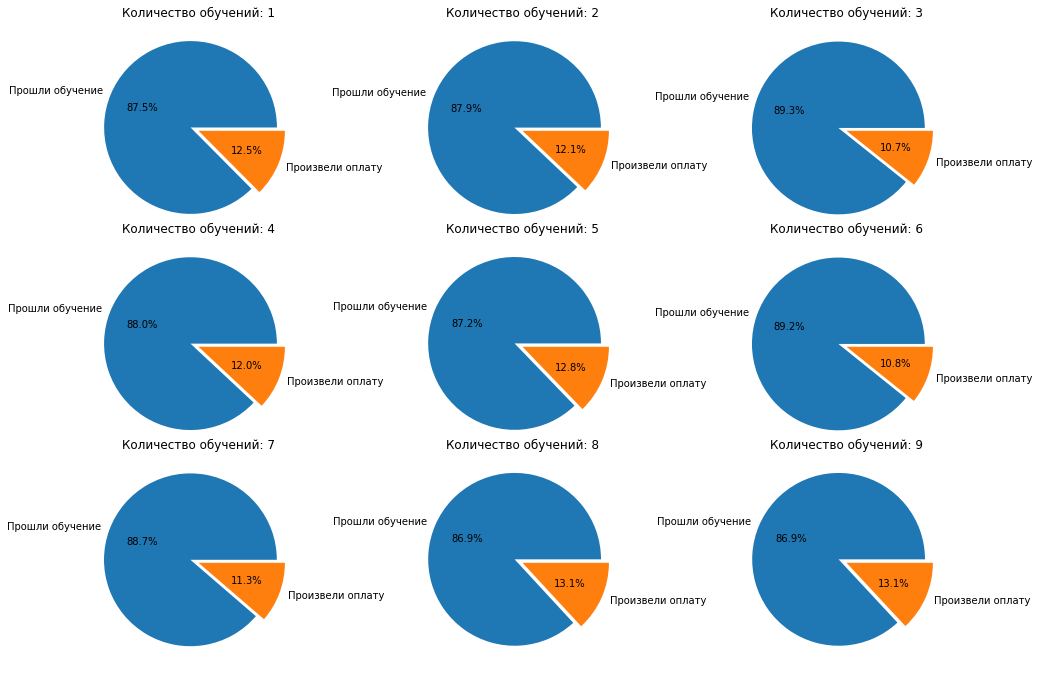

In [10]:
fig = plt.figure(figsize=(3, 3))

axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    df_group_1['count_user'],
    labels=df_group_1.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes.set_title('Количество обучений: 1')

axes2 = fig.add_axes([0, 0, 4, 1])
axes2.pie(
    df_group_2['count_user'],
    labels=df_group_2.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes2.set_title('Количество обучений: 2')

axes3 = fig.add_axes([0, 0, 7, 1])
axes3.pie(
    df_group_3['count_user'],
    labels=df_group_3.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes3.set_title('Количество обучений: 3')

axes4 = fig.add_axes([0, -1, 1, 1])
axes4.pie(
    df_group_4['count_user'],
    labels=df_group_4.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes4.set_title('Количество обучений: 4')

axes5 = fig.add_axes([0, -1, 4, 1])
axes5.pie(
    df_group_5['count_user'],
    labels=df_group_5.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes5.set_title('Количество обучений: 5')

axes6 = fig.add_axes([0, -1, 7, 1])
axes6.pie(
    df_group_6['count_user'],
    labels=df_group_6.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes6.set_title('Количество обучений: 6')

axes7 = fig.add_axes([0, -2, 1, 1])
axes7.pie(
    df_group_7['count_user'],
    labels=df_group_7.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes7.set_title('Количество обучений: 7')

axes8 = fig.add_axes([0, -2, 4, 1])
axes8.pie(
    df_group_8['count_user'],
    labels=df_group_8.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes8.set_title('Количество обучений: 8')

axes9 = fig.add_axes([0, -2, 7, 1])
axes9.pie(
    df_group_9['count_user'],
    labels=df_group_9.user_type,
    autopct='%.1f%%',
    explode = [0.1, 0]
);
axes9.set_title('Количество обучений: 9')

ВЫВОД: Из построенных диаграмм видно, что успешное обучение влияет на оплату. Между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь, существует зависимость. Вероятность оплаты состовляет в среднем от 10 до 13%. 

3. Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение? Т.е., определим, насколько прозрачен процесс взаимодействия с игрой. Для этого выясним, как часто пользователи начинают обучение после выбора уровня сложности. (если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [11]:
# Для анализа данной гипотезы, нам достаточно таблицы Events (events_df)

# отфильтруем таблицу по событию pack_choice (выбор уровня сложности)
events_pack_choice = events_df[events_df['event_type'] == 'pack_choice']

# создадим словарь для события pack_choice, где ключ - user_id, значение - start_time
dict_user_pack_choice = {}
# Цикл по строкам в отфильтрованной таблице
for index, row in events_pack_choice.iterrows(): 
    dict_user_pack_choice.setdefault(row['user_id'], row['start_time'])

print('Количество пользователй, которые выбрали уровень сложности:')
print(len(dict_user_pack_choice))

Количество пользователй, которые выбрали уровень сложности:
5737


In [12]:
# будущий список пользователей, которые начали обучение после выбора уровня сложности
users_after_pack_choice = []

# Цикл по таблице Events. Если для пользователя время события обучения позже, чем время события уровня сложности (хранится в словаре),
# вносим пользователя в список
for index, row in events_df[events_df['event_type'] == 'tutorial_start'].iterrows(): 
    try:
        if row['start_time'] > dict_user_pack_choice[row['user_id']]:
            users_after_pack_choice.append(row['user_id'])
    except:
        pass
    
print('Количество пользователй, которые начали обучение после выбора уровеня сложности:')
print(len(users_after_pack_choice))

Количество пользователй, которые начали обучение после выбора уровеня сложности:
1851


In [13]:
percent_of_usersafter_pack_choice = len(users_after_pack_choice) / len(dict_user_pack_choice)
print(
    "\nПроцент пользователей, которые возвращались к обучению после выбора уровня от всех, кто выбрал уровень: {:.2%}".format(
        percent_of_usersafter_pack_choice
    )
)


Процент пользователей, которые возвращались к обучению после выбора уровня от всех, кто выбрал уровень: 32.26%


ВЫВОД: 32% пользователей начинают обучение после выбора уровня сложности. Это достаточно большой процент, который означает, что многим пользователям непонятна работа с приложением.